binanin teze yoxsa kohne tikili olmasini nezere almaq ucun kod 

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)

# 1️⃣ Data load
df = pd.read_csv("../data/raw/bina_rent.csv")
print("Initial data shape:", df.shape)
display(df.head(3))


Initial data shape: (15000, 6)


,rooms,area_m2,floor_current,floor_total,location,price
0,4,105,9,17,"Elan №5746764 - Xırdalan, Xırdalan, 4 otaqlı, ...",580
1,1,50,17,17,"Elan №5752792 - Bakı, 20 Yanvar m., 1 otaqlı, ...",549
2,3,80,3,5,"Elan №5753561 - Bakı, Gənclik m., 3 otaqlı, 80...",699


In [15]:
# 2️⃣ Location təmizləmə
df['location_clean'] = df['location'].apply(lambda x: x.split(' - ')[-1])
df[['city', 'district']] = df['location_clean'].str.split(',', n=1, expand=True)
df['city'] = df['city'].str.strip()
df['district'] = df['district'].str.strip()
df['district'] = df['district'].apply(lambda x: x.split(',')[0].strip())

# Köhnə location sütunlarını sil
df.drop(columns=['location', 'location_clean'], inplace=True)

print("After location cleaning:")
display(df[['city','district']].head(10))


After location cleaning:


,city,district
0,Xırdalan,Xırdalan
1,Bakı,20 Yanvar m.
2,Bakı,Gənclik m.
3,Bakı,Nizami m.
4,Bakı,Koroğlu m.
5,Bakı,Neftçilər m.
6,Bakı,Əhmədli m.
7,Bakı,8 Noyabr m.
8,Bakı,İnşaatçılar m.
9,Bakı,Yeni Yasamal q.


In [16]:
# 3️⃣ Dataset info + basic stats
print("Dataset info:")
df.info()

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nDescriptive statistics:")
display(df.describe())
df.head(3)


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   rooms          15000 non-null  int64 
 1   area_m2        15000 non-null  int64 
 2   floor_current  15000 non-null  int64 
 3   floor_total    15000 non-null  int64 
 4   price          15000 non-null  int64 
 5   city           15000 non-null  object
 6   district       15000 non-null  object
dtypes: int64(5), object(2)
memory usage: 820.4+ KB

Missing values per column:
rooms            0
area_m2          0
floor_current    0
floor_total      0
price            0
city             0
district         0
dtype: int64

Descriptive statistics:


,rooms,area_m2,floor_current,floor_total,price
count,15000.000000,15000.000000,15000.00000,15000.000000,15000.000000
mean,2.480267,91.592800,7.90700,13.863267,1071.954333
std,0.728958,46.532546,4.92881,6.272830,741.212888
min,1.000000,1.000000,1.00000,1.000000,55.000000
25%,2.000000,64.000000,4.00000,9.000000,650.000000
50%,2.000000,80.000000,7.00000,16.000000,850.000000
75%,3.000000,110.000000,11.00000,18.000000,1250.000000
max,8.000000,1380.000000,27.00000,169.000000,14599.000000


,rooms,area_m2,floor_current,floor_total,price,city,district
0,4,105,9,17,580,Xırdalan,Xırdalan
1,1,50,17,17,549,Bakı,20 Yanvar m.
2,3,80,3,5,699,Bakı,Gənclik m.


Chattin atdigi 2 ci 10luq kimi

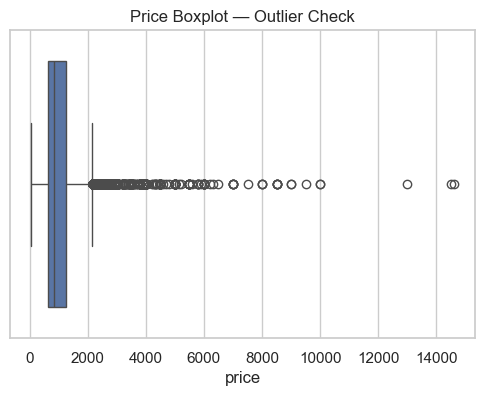

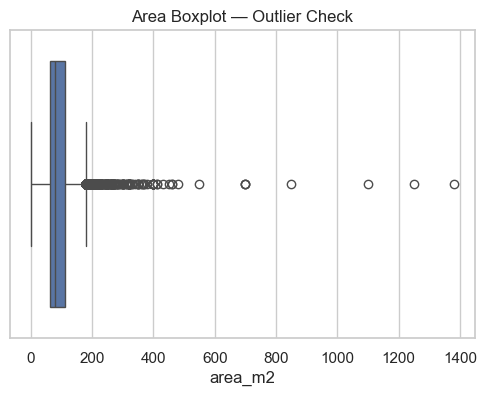

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
sns.boxplot(x=df['price'])
plt.title("Price Boxplot — Outlier Check")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x=df['area_m2'])
plt.title("Area Boxplot — Outlier Check")
plt.show()


In [18]:
# 1% və 99% quantiles
price_min, price_max = df['price'].quantile([0.01, 0.99])
area_min, area_max = df['area_m2'].quantile([0.01, 0.99])
rooms_min, rooms_max = df['rooms'].quantile([0.01, 0.99])

# Optional: hard-coded min/max to include reasonable higher values
# price_min = max(price_min, 200)       # minimal qiymət 200 AZN-dən aşağı olmasın
price_max = min(price_max, 2500)      # maksimal qiymət 2000 AZN-dən yüksək olmasın

print(f"Price 1%-99%: {price_min} — {price_max}")
print(f"Area 1%-99%: {area_min} — {area_max}")
print(f"Rooms 1%-99%: {rooms_min} — {rooms_max}")

# Filter dataset
df_clean = df[
    df['price'].between(price_min, price_max) &
    df['area_m2'].between(area_min, area_max) &
    df['rooms'].between(rooms_min, rooms_max) &
    (df['floor_current'] <= df['floor_total'])
].copy()

df_clean.reset_index(drop=True, inplace=True)
print("Before cleaning:", df.shape)
print("After cleaning:", df_clean.shape)


Price 1%-99%: 170.0 — 2500
Area 1%-99%: 30.0 — 230.0
Rooms 1%-99%: 1.0 — 4.0
Before cleaning: (15000, 7)
After cleaning: (14113, 7)


In [19]:
# Building type sütunu əlavə et (heuristic rule)
df_clean['building_type'] = df_clean['floor_total'].apply(lambda x: 'Teze tikili' if x > 11 else 'Kohne tikili')
df_clean[['floor_total', 'building_type']].head(10)


,floor_total,building_type
0,17,Teze tikili
1,17,Teze tikili
2,5,Kohne tikili
3,2,Kohne tikili
4,12,Teze tikili
5,9,Kohne tikili
6,14,Teze tikili
7,16,Teze tikili
8,9,Kohne tikili
9,5,Kohne tikili


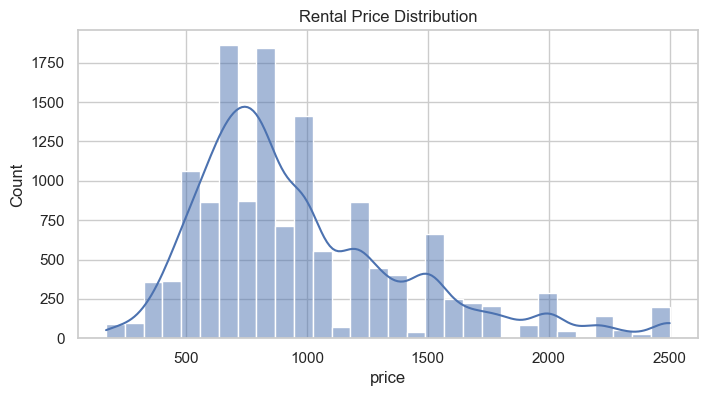

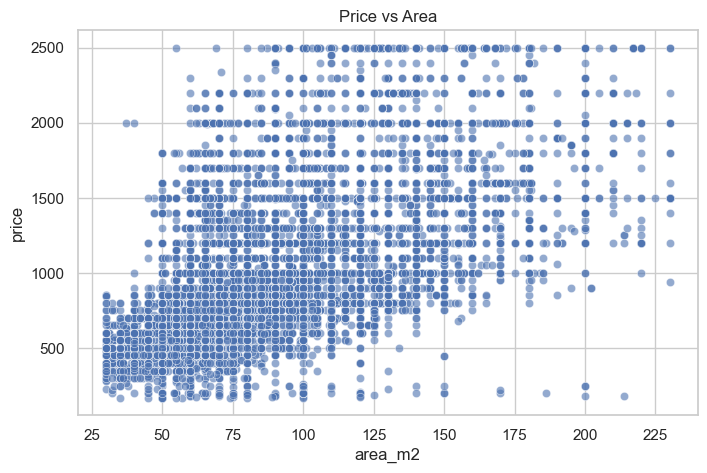

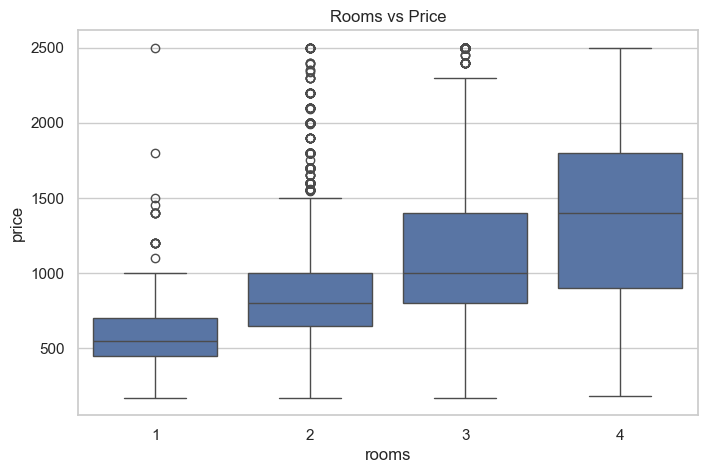

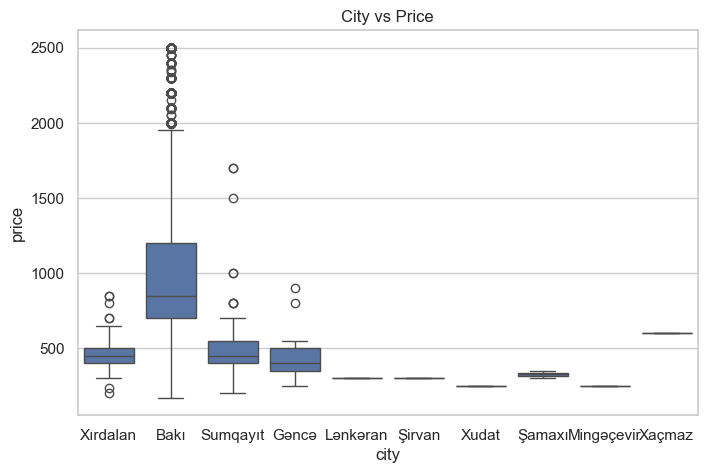

In [20]:
# Price distribution
plt.figure(figsize=(8,4))
sns.histplot(df_clean['price'], bins=30, kde=True)
plt.title("Rental Price Distribution")
plt.show()

# Price vs Area
plt.figure(figsize=(8,5))
sns.scatterplot(x='area_m2', y='price', data=df_clean, alpha=0.6)
plt.title("Price vs Area")
plt.show()

# Rooms vs Price
plt.figure(figsize=(8,5))
sns.boxplot(x='rooms', y='price', data=df_clean)
plt.title("Rooms vs Price")
plt.show()

# City vs Price
plt.figure(figsize=(8,5))
sns.boxplot(x='city', y='price', data=df_clean)
plt.title("City vs Price")
plt.show()


In [21]:
df_model = df_clean.copy()

# Floor ratio
df_model['floor_ratio'] = df_model['floor_current'] / df_model['floor_total']

# Encode building type
df_model['building_type_enc'] = df_model['building_type'].map({'Kohne tikili': 0, 'Teze tikili': 1})

# Encode city (Bakı / Other)
df_model['is_baku'] = (df_model['city'] == 'Bakı').astype(int)

# Target Encoding for district
# df_model['district_enc'] = df_model.groupby('district')['price'].transform('mean') 
# bu kod Data leakage e sebeb oldugu ucun commente saliram

# Drop old categorical columns
df_model.drop(columns=['city','building_type'], inplace=True)

df_model.head(3)


,rooms,area_m2,floor_current,floor_total,price,district,floor_ratio,building_type_enc,is_baku
0,4,105,9,17,580,Xırdalan,0.529412,1,0
1,1,50,17,17,549,20 Yanvar m.,1.000000,1,1
2,3,80,3,5,699,Gənclik m.,0.600000,0,1


Chattin atdigi 2 ci 10luq kimi baglanir

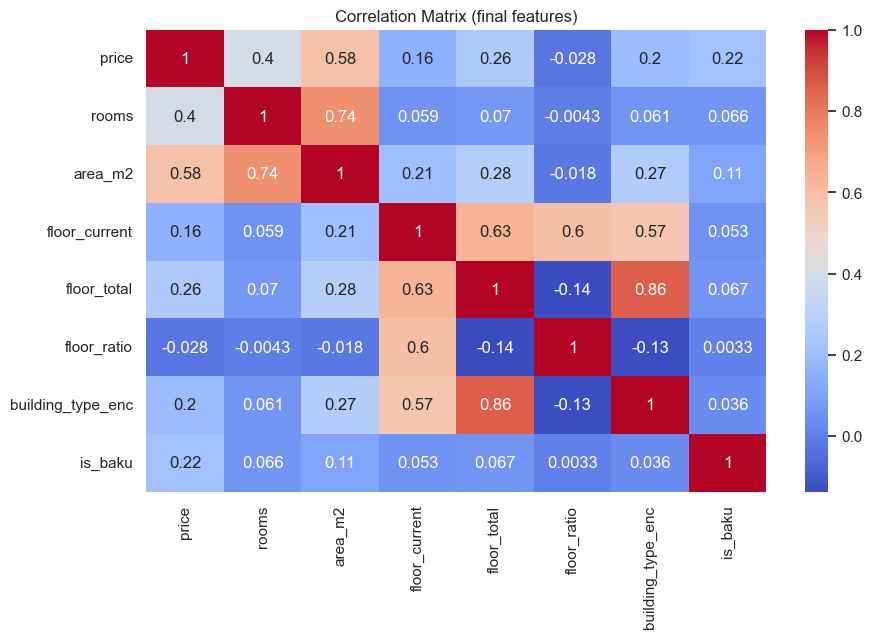

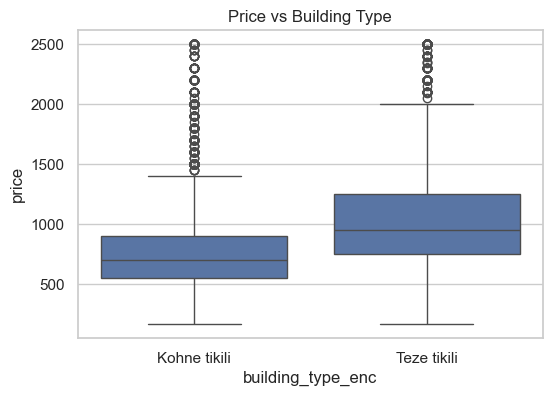

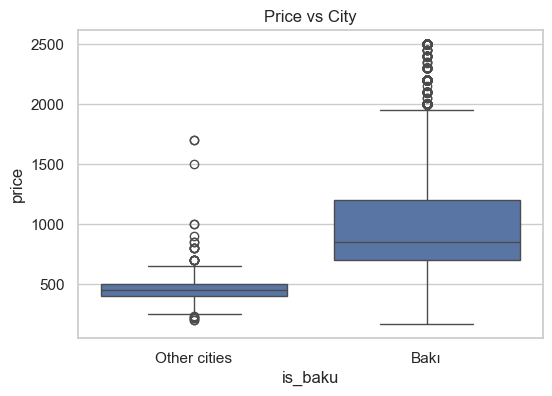

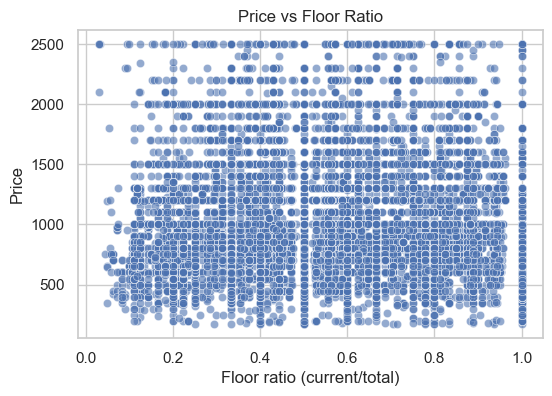

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Correlation matrix (numeric + encoded features)
corr_cols = ['price', 'rooms', 'area_m2', 'floor_current', 'floor_total', 
             'floor_ratio', 'building_type_enc', 'is_baku', ]

plt.figure(figsize=(10,6))
sns.heatmap(df_model[corr_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix (final features)")
plt.show()

# 2️⃣ Price vs Building Type
plt.figure(figsize=(6,4))
sns.boxplot(x='building_type_enc', y='price', data=df_model)
plt.xticks([0,1], ['Kohne tikili','Teze tikili'])
plt.title("Price vs Building Type")
plt.show()

# 3️⃣ Price vs City (Bakı / Other)
plt.figure(figsize=(6,4))
sns.boxplot(x='is_baku', y='price', data=df_model)
plt.xticks([0,1], ['Other cities','Bakı'])
plt.title("Price vs City")
plt.show()

# 4️⃣ Price vs Floor Ratio
plt.figure(figsize=(6,4))
sns.scatterplot(x='floor_ratio', y='price', data=df_model, alpha=0.6)
plt.title("Price vs Floor Ratio")
plt.xlabel("Floor ratio (current/total)")
plt.ylabel("Price")
plt.show()




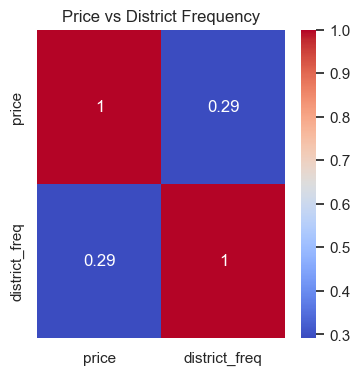

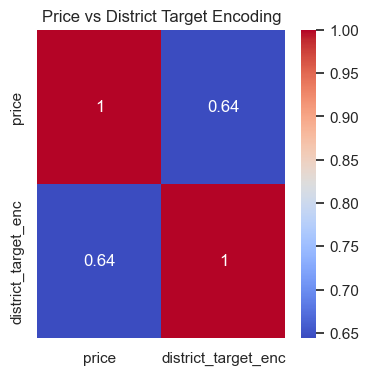

In [23]:
# Count Encoding
district_count = df_clean['district'].value_counts()
df_model['district_freq'] = df_clean['district'].map(district_count)

# Correlation yoxlamaq
plt.figure(figsize=(4,4))
sns.heatmap(df_model[['price', 'district_freq']].corr(), annot=True, cmap='coolwarm')
plt.title("Price vs District Frequency")
plt.show()

# Target Encoding
district_mean_price = df_clean.groupby('district')['price'].mean()
df_model['district_target_enc'] = df_clean['district'].map(district_mean_price)

# Correlation yoxlamaq
plt.figure(figsize=(4,4))
sns.heatmap(df_model[['price', 'district_target_enc']].corr(), annot=True, cmap='coolwarm')
plt.title("Price vs District Target Encoding")
plt.show()


In [24]:
df_clean.to_csv("../data/processed/bina_rent_clean.csv", index=False)
df_model.to_csv("../data/processed/bina_rent_model.csv", index=False)


In [25]:
df_model.head(3)

,rooms,area_m2,floor_current,floor_total,price,district,floor_ratio,building_type_enc,is_baku,district_freq,district_target_enc
0,4,105,9,17,580,Xırdalan,0.529412,1,0,334,459.200599
1,1,50,17,17,549,20 Yanvar m.,1.000000,1,1,620,771.066129
2,3,80,3,5,699,Gənclik m.,0.600000,0,1,521,966.310940
